# GPT-Q

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import torch
from pennylane import numpy as np

torch.set_printoptions(precision=3)

In [55]:
from models import QConv1d

ks = 5  # kind of arbitrary, limited by the number of available qubits
p = (ks - 1) // 2

qconv = QConv1d(kernel_size=ks, out_channels=3, n_qlayers=1, stride=1, padding=p)
qconv.draw()

 0: ──RX(0)──RX(3.06)───╭C──────────────╭X──┤ ⟨Z⟩ 
 1: ──RX(0)──RX(3.18)───╰X──╭C──────────│───┤ ⟨Z⟩ 
 2: ──RX(0)──RX(1.65)───────╰X──╭C──────│───┤ ⟨Z⟩ 
 3: ──RX(0)──RX(0.309)──────────╰X──╭C──│───┤     
 4: ──RX(0)──RX(4.17)───────────────╰X──╰C──┤     



In [56]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.310, 0.500, 0.655, 0.777, 0.563, 0.625, 0.045, 0.495],
         [0.071, 0.888, 0.020, 0.053, 0.069, 0.692, 0.083, 0.517],
         [0.164, 0.454, 0.252, 0.570, 0.795, 0.342, 0.162, 0.544],
         [0.562, 0.461, 0.636, 0.300, 0.554, 0.463, 0.585, 0.177]]])


In [57]:
z = qconv(x)
print(z.shape)

torch.Size([1, 4, 8, 3])


In [58]:
z[:, :, :, 0].shape

torch.Size([1, 4, 8])

In [59]:
zc = z.view((1, 4, embed_dim*3))
print(zc.shape)

torch.Size([1, 4, 24])


1 + (c*w + 2*p - k) / s = w
=> (c*w - k) / s = w - 1
=> s = (c*w - k) / (w - 1)
this has to be an integer.

n = (c*w - k) / (w - 1) => n * (w - 1) = c*w - k => k = c*w - n * (w - 1)
k = (3 - n) * w + n, 0 < k < 3*w

In [60]:
def find_k(w, c):
    for n in range(10):
        # n = (b*w - k) / (d - 1) => n * (d - 1) = b*w - k => k = b*w - n*w + n
        k = c*w - n * (w - 1)
        if k < 0:
            break
        print(k)

find_k(embed_dim, 4)

32
25
18
11
4


In [61]:
ks_inv = 3
stride_inv = (3 * embed_dim - ks_inv) // (embed_dim - 1)
print(f"kernel size (=no. of qubits): {ks_inv}")
print(f"stride: {stride_inv}")
qconv_inv = QConv1d(kernel_size=ks_inv, out_channels=1, n_qlayers=1, stride=stride_inv, padding=0)
qconv_inv.draw()

kernel size (=no. of qubits): 3
stride: 3
 0: ──RX(0)──RX(0.386)──╭C──────╭X──┤ ⟨Z⟩ 
 1: ──RX(0)──RX(5.78)───╰X──╭C──│───┤     
 2: ──RX(0)──RX(0.339)──────╰X──╰C──┤     



In [62]:
y = qconv_inv(zc).view((batch_size, seq_len, -1))
print(y.shape)

torch.Size([1, 4, 8])


In [63]:
x = torch.arange(24).view(1, 2, 4, 3)
print(x)

tensor([[[[ 0,  1,  2],
          [ 3,  4,  5],
          [ 6,  7,  8],
          [ 9, 10, 11]],

         [[12, 13, 14],
          [15, 16, 17],
          [18, 19, 20],
          [21, 22, 23]]]])


In [64]:
x = x.transpose(-1,-2).view(1,2,3,-1)
print(x)
x = x.reshape((1,2,12))
print(x)


tensor([[[[ 0,  3,  6,  9],
          [ 1,  4,  7, 10],
          [ 2,  5,  8, 11]],

         [[12, 15, 18, 21],
          [13, 16, 19, 22],
          [14, 17, 20, 23]]]])
tensor([[[ 0,  3,  6,  9,  1,  4,  7, 10,  2,  5,  8, 11],
         [12, 15, 18, 21, 13, 16, 19, 22, 14, 17, 20, 23]]])


In [65]:
print(zc)
zc.transpose(-1, -2)

tensor([[[ 2.837e-02,  9.960e-01, -3.804e-01,  6.729e-02,  9.375e-01,
          -5.154e-01,  4.412e-03,  8.373e-01, -5.624e-01,  2.919e-02,
           7.044e-01, -5.332e-01, -1.181e-01,  5.778e-01, -3.474e-01,
          -2.614e-02,  6.345e-01, -4.119e-01, -3.615e-02,  7.000e-01,
          -8.884e-02, -2.691e-01,  8.537e-01, -4.654e-01],
         [-2.798e-02,  9.960e-01, -1.521e-01, -3.674e-01,  9.908e-01,
          -8.172e-01, -2.644e-02,  6.025e-01, -6.152e-02,  1.809e-02,
           6.916e-01, -9.328e-02, -3.616e-02,  9.941e-01, -1.496e-01,
          -1.908e-02,  9.940e-01, -6.946e-01, -4.321e-02,  7.465e-01,
          -1.226e-01, -2.772e-01,  8.142e-01, -4.589e-01],
         [-5.107e-02,  9.960e-01, -2.425e-01,  9.954e-03,  9.767e-01,
          -4.985e-01,  4.539e-02,  8.794e-01, -2.882e-01, -5.328e-02,
           8.934e-01, -5.421e-01, -1.886e-01,  8.099e-01, -6.228e-01,
          -7.285e-04,  5.951e-01, -2.446e-01, -7.682e-02,  7.031e-01,
          -1.699e-01, -2.843e-01,  9.476e-

tensor([[[ 2.837e-02, -2.798e-02, -5.107e-02,  3.846e-02],
         [ 9.960e-01,  9.960e-01,  9.960e-01,  9.960e-01],
         [-3.804e-01, -1.521e-01, -2.425e-01, -5.977e-01],
         [ 6.729e-02, -3.674e-01,  9.954e-03, -6.114e-02],
         [ 9.375e-01,  9.908e-01,  9.767e-01,  8.237e-01],
         [-5.154e-01, -8.172e-01, -4.985e-01, -4.256e-01],
         [ 4.412e-03, -2.644e-02,  4.539e-02,  3.345e-03],
         [ 8.373e-01,  6.025e-01,  8.794e-01,  7.798e-01],
         [-5.624e-01, -6.152e-02, -2.882e-01, -5.130e-01],
         [ 2.919e-02,  1.809e-02, -5.328e-02, -1.575e-02],
         [ 7.044e-01,  6.916e-01,  8.934e-01,  7.269e-01],
         [-5.332e-01, -9.328e-02, -5.421e-01, -2.707e-01],
         [-1.181e-01, -3.616e-02, -1.886e-01,  1.525e-02],
         [ 5.778e-01,  9.941e-01,  8.099e-01,  8.030e-01],
         [-3.474e-01, -1.496e-01, -6.228e-01, -4.767e-01],
         [-2.614e-02, -1.908e-02, -7.285e-04, -9.751e-02],
         [ 6.345e-01,  9.940e-01,  5.951e-01,  8.114e-01

## FeedForward

In [77]:
from models import FeedForward

embed_dim = 8
n_qubits = 5
n_qlayers = 1
boom_factor = 4
ff = FeedForward(embed_dim, boom_factor=boom_factor, n_qubits=n_qubits, n_qlayers=n_qlayers)

In [81]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))

print("input:", x.shape)
xff = ff.forward(x)
print("output:", xff.shape)

input: torch.Size([1, 4, 8])
output: torch.Size([1, 4, 8])


## Attention

In [9]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.964, 0.776, 0.797, 0.132, 0.005, 0.225, 0.763, 0.818],
         [0.998, 0.020, 0.987, 0.329, 0.430, 0.608, 0.548, 0.698],
         [0.829, 0.442, 0.601, 0.259, 0.688, 0.809, 0.910, 0.808],
         [0.446, 0.084, 0.925, 0.620, 0.958, 0.173, 0.355, 0.116]]])


In [82]:
from models import MultiHeadAttention

n_heads = 2
n_qubits = 5
n_qlayers = 1
n_heads = 4

attn = MultiHeadAttention(embed_dim, n_heads, n_qubits, n_qlayers)

In [83]:
out = attn(x)
print("output of attention:", out.shape)

output of attention: torch.Size([1, 4, 8])


## Transformer block

In [84]:
from models import TransformerBlock

transformer = TransformerBlock(embed_dim, n_heads=n_heads, n_qubits=n_qubits, n_qlayers=n_qlayers)

In [85]:
x_tf = transformer.forward(x)
print("transformer block output:", x_tf.shape)

transformer block output: torch.Size([1, 4, 8])


## GPT-Q Full Model

In [92]:
from models import GPTQ

batch_size = 1
max_seq_len = 16
src_vocab = 8
tgt_vocab = 4 
n_layers = 2
n_heads = 4

gptq = GPTQ(embed_dim=embed_dim, src_vocab=src_vocab, tgt_vocab=tgt_vocab, n_heads=n_heads, n_layers=n_layers)

In [93]:
token_ids = np.random.choice(src_vocab, (batch_size, max_seq_len))
token_ids = torch.tensor(token_ids)
print(token_ids)

tensor([[1, 4, 4, 0, 7, 2, 5, 1, 4, 5, 0, 3, 1, 2, 0, 2]])


In [94]:
out = gptq(token_ids)
print("GPT-Q output:", out.shape)

GPT-Q output: torch.Size([1, 16, 4])


## Masks

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

from utils import make_padding_mask, make_subsequent_mask, make_lookahead_mask

In [18]:
token_ids = np.random.choice(src_vocab, (batch_size, max_seq_len))
token_ids = torch.tensor(token_ids)
print(token_ids)

tensor([[2, 5, 5, 3, 6, 6, 6, 1, 2, 0, 6, 4, 3, 0, 4, 7]])


In [19]:
make_padding_mask(token_ids)

tensor([[[ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
           True,  True,  True, False,  True,  True]]])

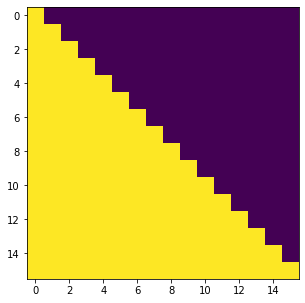

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(make_subsequent_mask(max_seq_len)[0])

In [21]:
make_lookahead_mask(token_ids)

tensor([[[ True, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, Fal

## Train Classifier

In [44]:
from torchtext.datasets import IMDB

In [45]:
train_iter, test_iter = IMDB(split=('train', 'test'))

In [46]:
len(train_iter), len(test_iter)

(25000, 25000)

In [47]:
train_data = []
for label, line in train_iter:
    train_data.append(line)
print(train_data[:3])

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [48]:
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, decoders, trainers

vocab_size = 300
min_frequency = 2
special_tokens = [
        "<s>",
        "<pad>",
        "</s>",
        "<unk>",
        "<mask>",
    ]

tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
tokenizer.decoders = decoders.ByteLevel()

trainer = trainers.BpeTrainer(
    vocab_size=vocab_size,
    initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
    min_frequency=min_frequency,
    special_tokens=special_tokens)

tokenizer.train_from_iterator(train_data, trainer=trainer)
tokenizer.save("gptq.json")

In [49]:
tokenizer.encode("Hello world").ids

[225, 44, 73, 287, 83, 268, 282, 80, 72]

## Fit Model

In [95]:
from models import IMDbClassifier, LanguageModel

max_seq_len = 64
n_layers = 1
n_heads = 2
lr = 1e-3

model = IMDbClassifier(embed_dim=embed_dim,
                       vocab_size=vocab_size,
                       n_heads=n_heads,
                       n_layers=n_layers)

In [103]:
from dataset import IMDbDataModule

BATCH_SIZE = 32
n_examples_max = 10

dm = IMDbDataModule(val_split=0.2, batch_size=BATCH_SIZE, max_seq_length=max_seq_len, n_examples_max=n_examples_max)

In [104]:
from pytorch_lightning import Trainer

AVAIL_GPUS = min(1, torch.cuda.device_count())

trainer = Trainer(
    max_epochs=10,
    gpus=AVAIL_GPUS,
    log_every_n_steps=2,
    progress_bar_refresh_rate=20)
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.core.lightning:
  | Name    | Type             | Params
---------------------------------------------
0 | h       | ModuleList       | 51    
1 | wte     | Embedding        | 2.4 K 
2 | wpe     | Embedding        | 8.2 K 
3 | dropout | Dropout          | 0     
4 | ln_f    | LayerNorm        | 16    
5 | out     | Linear           | 16    
6 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
10.7 K    Trainable params
0         Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=2). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [98]:
torch.save(model.state_dict(), "imdb_classifier.pt")

In [99]:
%load_ext tensorboard

In [101]:
%tensorboard --logdir ./lightning_logs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
